In [1]:
%%capture
! pip install transformers datasets

In [2]:
# The basics
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random

# For Data processing
import nltk
import string
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import TweetTokenizer
from datetime import datetime

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# For the GloVe model
import gzip
import logging
import os
import tarfile
import zipfile
from functools import partial
import torch.optim
from urllib.request import urlretrieve
from tqdm import tqdm
from torchtext.utils import reporthook
import torch


In [3]:
def who_am_i():  # this is not a class method
    """Returns a ductionary with your name, id number and email. keys=['name', 'id','email']
        Make sure you return your own info!
    """
    return {'name': 'Alon Schneider | Alon Malach', 'id': '312213978 | 207024878', 'email': 'alonshn@post.bgu.ac.il | alonmal@post.bgu.ac.il'}

In [4]:
who_am_i()

{'name': 'Alon Schneider | Alon Malach',
 'id': '312213978 | 207024878',
 'email': 'alonshn@post.bgu.ac.il | alonmal@post.bgu.ac.il'}

In [5]:
global device
global seed
global trump_path

seed = int((312213978 + 207024878)/2) # the mean of our ids
trump_path = '/content/trump_train.tsv' # the path to the train data    <<----------------->>   CHANGE HERE TO YOUR PATH !!!

# Planting the seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("seed: " + str(seed))
device

seed: 259619428


device(type='cuda')

# Preproccess for Authorship attribution

## Importing GloVe

### This code helps us to import the GloVe model by PyTorch, we couldn't import it normally so we had to manually change the url in the library to download the pretrained components from another source on the internet (this time it was from hugging face)

In [6]:
logger = logging.getLogger(__name__)


def _infer_shape(f):
    num_lines, vector_dim = 0, None
    for line in f:
        if vector_dim is None:
            row = line.rstrip().split(b" ")
            vector = row[1:]
            # Assuming word, [vector] format
            if len(vector) > 2:
                # The header present in some (w2v) formats contains two elements.
                vector_dim = len(vector)
                num_lines += 1  # First element read
        else:
            num_lines += 1
    f.seek(0)
    return num_lines, vector_dim


class Vectors(object):
    def __init__(self, name, cache=None, url=None, unk_init=None, max_vectors=None) -> None:
        """
        Args:

            name: name of the file that contains the vectors
            cache: directory for cached vectors
            url: url for download if vectors not found in cache
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and returns a Tensor of the same size
            max_vectors (int): this can be used to limit the number of
                pre-trained vectors loaded.
                Most pre-trained vector sets are sorted
                in the descending order of word frequency.
                Thus, in situations where the entire set doesn't fit in memory,
                or is not needed for another reason, passing `max_vectors`
                can limit the size of the loaded set.
        """

        cache = ".vector_cache" if cache is None else cache
        self.itos = None
        self.stoi = None
        self.vectors = None
        self.dim = None
        self.unk_init = torch.Tensor.zero_ if unk_init is None else unk_init
        self.cache(name, cache, url=url, max_vectors=max_vectors)

    def __getitem__(self, token):
        if token in self.stoi:
            return self.vectors[self.stoi[token]]
        else:
            return self.unk_init(torch.Tensor(self.dim))

    def cache(self, name, cache, url=None, max_vectors=None):
        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context
        if os.path.isfile(name):
            path = name
            if max_vectors:
                file_suffix = "_{}.pt".format(max_vectors)
            else:
                file_suffix = ".pt"
            path_pt = os.path.join(cache, os.path.basename(name)) + file_suffix
        else:
            path = os.path.join(cache, name)
            if max_vectors:
                file_suffix = "_{}.pt".format(max_vectors)
            else:
                file_suffix = ".pt"
            path_pt = path + file_suffix

        if not os.path.isfile(path_pt):
            if not os.path.isfile(path) and url:
                logger.info("Downloading vectors from {}".format(url))
                if not os.path.exists(cache):
                    os.makedirs(cache)
                dest = os.path.join(cache, os.path.basename(url))
                if not os.path.isfile(dest):
                    with tqdm(unit="B", unit_scale=True, miniters=1, desc=dest) as t:
                        try:
                            urlretrieve(url, dest, reporthook=reporthook(t))
                        except KeyboardInterrupt as e:  # remove the partial zip file
                            os.remove(dest)
                            raise e
                logger.info("Extracting vectors into {}".format(cache))
                ext = os.path.splitext(dest)[1][1:]
                if ext == "zip":
                    with zipfile.ZipFile(dest, "r") as zf:
                        zf.extractall(cache)
                elif ext == "gz":
                    if dest.endswith(".tar.gz"):
                        with tarfile.open(dest, "r:gz") as tar:
                            tar.extractall(path=cache)
            if not os.path.isfile(path):
                raise RuntimeError("no vectors found at {}".format(path))

            logger.info("Loading vectors from {}".format(path))
            ext = os.path.splitext(path)[1][1:]
            if ext == "gz":
                open_file = gzip.open
            else:
                open_file = open

            vectors_loaded = 0
            with open_file(path, "rb") as f:
                num_lines, dim = _infer_shape(f)
                if not max_vectors or max_vectors > num_lines:
                    max_vectors = num_lines

                itos, vectors, dim = [], torch.zeros((max_vectors, dim)), None

                for line in tqdm(f, total=max_vectors):
                    # Explicitly splitting on " " is important, so we don't
                    # get rid of Unicode non-breaking spaces in the vectors.
                    entries = line.rstrip().split(b" ")

                    word, entries = entries[0], entries[1:]
                    if dim is None and len(entries) > 1:
                        dim = len(entries)
                    elif len(entries) == 1:
                        logger.warning(
                            "Skipping token {} with 1-dimensional " "vector {}; likely a header".format(word, entries)
                        )
                        continue
                    elif dim != len(entries):
                        raise RuntimeError(
                            "Vector for token {} has {} dimensions, but previously "
                            "read vectors have {} dimensions. All vectors must have "
                            "the same number of dimensions.".format(word, len(entries), dim)
                        )

                    try:
                        if isinstance(word, bytes):
                            word = word.decode("utf-8")
                    except UnicodeDecodeError:
                        logger.info("Skipping non-UTF8 token {}".format(repr(word)))
                        continue

                    vectors[vectors_loaded] = torch.tensor([float(x) for x in entries])
                    vectors_loaded += 1
                    itos.append(word)

                    if vectors_loaded == max_vectors:
                        break

            self.itos = itos
            self.stoi = {word: i for i, word in enumerate(itos)}
            self.vectors = torch.Tensor(vectors).view(-1, dim)
            self.dim = dim
            logger.info("Saving vectors to {}".format(path_pt))
            if not os.path.exists(cache):
                os.makedirs(cache)
            torch.save((self.itos, self.stoi, self.vectors, self.dim), path_pt)
        else:
            logger.info("Loading vectors from {}".format(path_pt))
            self.itos, self.stoi, self.vectors, self.dim = torch.load(path_pt)

    def __len__(self):
        return len(self.vectors)

    def get_vecs_by_tokens(self, tokens, lower_case_backup=False):
        """Look up embedding vectors of tokens.

        Args:
            tokens: a token or a list of tokens. if `tokens` is a string,
                returns a 1-D tensor of shape `self.dim`; if `tokens` is a
                list of strings, returns a 2-D tensor of shape=(len(tokens),
                self.dim).
            lower_case_backup : Whether to look up the token in the lower case.
                If False, each token in the original case will be looked up;
                if True, each token in the original case will be looked up first,
                if not found in the keys of the property `stoi`, the token in the
                lower case will be looked up. Default: False.

        Examples:
            >>> examples = ['chip', 'baby', 'Beautiful']
            >>> vec = text.vocab.GloVe(name='6B', dim=50)
            >>> ret = vec.get_vecs_by_tokens(examples, lower_case_backup=True)
        """
        to_reduce = False

        if not isinstance(tokens, list):
            tokens = [tokens]
            to_reduce = True

        if not lower_case_backup:
            indices = [self[token] for token in tokens]
        else:
            indices = [self[token] if token in self.stoi else self[token.lower()] for token in tokens]

        vecs = torch.stack(indices)
        return vecs[0] if to_reduce else vecs

# the original url doesnt work - had to manualy insert a new url that contains the zip file.
# https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
glove_840b300d_URL = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip"
class GloVe(Vectors):
    url = {
        "42B": "http://nlp.stanford.edu/data/glove.42B.300d.zip",
        "840B": glove_840b300d_URL,
        "twitter.27B": "http://nlp.stanford.edu/data/glove.twitter.27B.zip",
        "6B": "http://nlp.stanford.edu/data/glove.6B.zip",
    }

    def __init__(self, name="840B", dim=300, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        super(GloVe, self).__init__(name, url=url, **kwargs)

## get glove model

In [7]:
glove = GloVe(name='840B', dim=300) # takes about 10 minutes

In [8]:
glove['glove'].shape

torch.Size([300])

In [9]:
train_data = pd.read_csv('/content/trump_train.tsv', sep='\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])

Lets take a look at the data set!

In [10]:
train_data.head(5)

,tweet_id,user_handle,tweet_text,timestamp,device
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android


In [11]:
def preprocess(df, just_df=False, include_vectors=True):

  df.dropna()
  min_max_scaler = MinMaxScaler()
  embeddings = []

  df.loc[df['device'] == 'android', 'device'] = 0
  df.loc[df['device'] != 0, 'device'] = 1

  # we handle the timestamps
  def apply_time(data):
    handle_time = lambda x: datetime.strptime(x['timestamp'], '%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')
    try:
        return int(handle_time(data))
    except:
        return None
  df.dropna()
  df["timestamp"] = min_max_scaler.fit_transform(df.apply(apply_time,axis=1).to_numpy().reshape(-1,1))

  # Now we can tokenize
  tweet_tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
  df["tokens"] = df.apply(lambda x: tweet_tokenizer.tokenize(x.tweet_text),axis=1)

  ##### Let's create more features! #####

  # Features we think are more likely to represent Trump
  count_twit_uppers = lambda x: sum([1 for char in x.tweet_text if char.isupper()])
  df["uppercase_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_uppers,axis=1).to_numpy().reshape(-1,1))

  count_twit_hash = lambda x: x.tweet_text.count("#")
  df["hashtags_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_hash,axis=1).to_numpy().reshape(-1,1))

  count_twit_puncts = lambda x: sum([1 for char in x['tweet_text'] if char in string.punctuation])
  df['puncts_counts'] = min_max_scaler.fit_transform(df.apply(count_twit_puncts,axis=1).to_numpy().reshape(-1,1))

  count_twit_tags = lambda x: x.tweet_text.count("@")
  df["tag_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_tags,axis=1).to_numpy().reshape(-1,1))

  # general features that might help
  twitt_len = lambda x: len(x.tokens)
  df["len"] = min_max_scaler.fit_transform(df.apply(twitt_len,axis=1).to_numpy().reshape(-1,1))

  count_twit_digits = lambda x:  sum([char.isdigit() for char in x.tweet_text])
  df["digit_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_digits, axis=1).to_numpy().reshape(-1,1))

  count_twit_urls = lambda x: x.tweet_text.count("https")
  df["https_counts"] = min_max_scaler.fit_transform(df.apply(count_twit_urls,axis=1).to_numpy().reshape(-1,1))

  df.rename(columns={'device': 'target'}, inplace=True)
  if just_df:
    return df

  # Creating embedded representations
  for i in range(len(df)):
    embedded_vectors = []
    for token in df.iloc[i].tokens:
      embedded_vectors.append(glove[token])
    embeddings.append(embedded_vectors) # the list embeddings contains for each row a list of the embedded tokens.

  # lets create some embeddings features!
  embedded_features = {}

  sum_tensors = lambda tensor_list: sum(tensor_list)
  summed_embeds = np.array([sum_tensors(lst).numpy() for lst in embeddings])
  embedded_features['summed_embeds'] = summed_embeds

  average_tensors = lambda tensor_list: sum(tensor_list) / len(tensor_list)
  averaged_embeds = np.array([average_tensors(lst).numpy() for lst in embeddings])
  embedded_features['averaged_embeds'] = averaged_embeds

  sum_div_avg_embed = np.divide(summed_embeds, averaged_embeds, where=averaged_embeds!=0)
  embedded_features['sum_div_avg_embed'] = sum_div_avg_embed
  # embedded_features['sum_div_avg_embed'] = embedded_features['sum_div_avg_embed'].replace([np.inf, -np.inf, np.nan], 0)
  embedded_features['sum_div_avg_embed'] = list(np.where(np.isinf(embedded_features['sum_div_avg_embed']) | np.isnan(embedded_features['sum_div_avg_embed']), 0, embedded_features['sum_div_avg_embed']))
  embedded_features['sum_div_avg_embed'] = min_max_scaler.fit_transform(np.array([sum(lst)/len(lst) for lst in embedded_features['sum_div_avg_embed']]).reshape(-1,1))


  avg_div_sum = np.divide(averaged_embeds, summed_embeds, where=summed_embeds!=0)
  embedded_features['avg_div_sum'] = avg_div_sum

  # embedded_features['avg_div_sum'] = embedded_features['avg_div_sum'].replace([np.inf, -np.inf, np.nan], 0)
  embedded_features['avg_div_sum'] = list(np.where(np.isinf(embedded_features['avg_div_sum']) | np.isnan(embedded_features['avg_div_sum']), 0, embedded_features['avg_div_sum']))

  embedded_features['avg_div_sum'] = min_max_scaler.fit_transform(np.array([sum(lst)/len(lst) for lst in embedded_features['avg_div_sum']]).reshape(-1,1))

  embedded_features['sum_times_avg'] = list(summed_embeds*averaged_embeds)

  embedded_features['summed_embeds'] = list(summed_embeds)

  embedded_features['averaged_embeds'] = list(averaged_embeds)


  df = df.assign(**embedded_features) # adding the embeddings features to the df

  if include_vectors:
    selected_features = ['target','uppercase_counts','hashtags_counts','puncts_counts','tag_counts','len','digit_counts','https_counts','sum_div_avg_embed','avg_div_sum','summed_embeds','averaged_embeds','sum_times_avg']
    tmp = df[selected_features]
    data, labels = tmp[selected_features[1:]], tmp['target']
    tensor_list = []
    # vector_cols = ['summed_embeds','averaged_embeds','sum_times_avg']
    vector_cols = ['summed_embeds','averaged_embeds','sum_times_avg']
    # Iterate over rows in the DataFrame
    for _, row in data.iterrows():
        # Get the numbers and vectors
        numbers = torch.tensor(row.drop(vector_cols).values.astype(np.float32))
        vectors = torch.cat([torch.tensor(v, dtype=torch.float32) for v in row[vector_cols].values])

        # Concatenate the numbers and vectors and add to the list
        tensor_list.append(torch.cat((numbers, vectors)))

    # Stack all tensors in the list into a larger tensor
    final_tensor = torch.stack(tensor_list)

    return final_tensor, labels, data, df, embeddings
  else:
    return df, embeddings

In [12]:
data_tensors, labels, data, df, embeddings = preprocess(train_data)

# Neural Models for Authorship attribution

## FFNN for Authorship attribution

In [13]:
class FFNN(nn.Module):
    def __init__(self, input_dim=909, output_dim=1, hidden_layers=[256,128,32,16,8], dropout_rate=0.3):
        super(FFNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_layers[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            *[nn.Sequential(nn.Linear(hidden_layers[i-1], hidden_layers[i]),
                            nn.ReLU(inplace=True),
                            nn.Dropout(dropout_rate)) for i in range(1, len(hidden_layers))],
            nn.Linear(hidden_layers[-1], output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x



In [14]:
class FFNNDataset(Dataset):
    def __init__(self, X, labels):
        self.X = X
        self.labels = labels
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = self.X[index]
        y = self.labels[index]
        return x, y

In [15]:
def train_FFNN_weights(model, X_train, X_val, train_y, y_val, criterion, optimizer, num_epochs=32, lr=0.001, batch=32):
    def model_validation_evaluator(model, criterion, data_loader):
        model.eval()
        total_loss, total_correct, elements_count = 0.0, [], []
        threshold = 0.5

        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            with torch.no_grad():
                outputs = model(X)
                outputs = outputs.view(-1)
                loss = criterion(outputs, y)

                total_loss += loss.item()

                predicted = (outputs > threshold).float()
                total_correct.append((predicted == y).sum().item())
                elements_count.append(len(y))

        Validation_accuracies = [num1 / num2 for num1, num2 in zip(total_correct, elements_count)]
        Average_accuracy = sum(Validation_accuracies) / len(Validation_accuracies)
        Average_loss = total_loss / len(data_loader)

        return Average_loss, Average_accuracy

    train, val = FFNNDataset(X_train, train_y), FFNNDataset(X_val, y_val)
    train_DL, val_DL = DataLoader(train, batch_size=batch, shuffle=True), DataLoader(val, batch_size=batch, shuffle=False)

    threshold = 0.5

    stats = {
        'average_epoch_acc':[],
        'validation_accuracy':[],
        'average_accumulated_loss':[],
        'validation_loss':[],
        'training_time':[]
             }

    for epoch in range(num_epochs):
        s_time = time.time()
        model.train()

        curr_epoch_accuracy = []
        curr_epoch_accumulated_loss = 0.0
        for (X, y) in train_DL:

            X, y = X.to(device), y.to(device)

            y_preds = model(X)
            y_preds = y_preds.view(-1)

            loss = criterion(y_preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            curr_epoch_accumulated_loss += loss.item()

            # lets handle the predictions
            pred = (y_preds > threshold).float()

            # evaluate accuracy
            Trues = (pred == y).sum().item()
            acc = Trues / len(y)
            curr_epoch_accuracy.append(acc)

        # Now we will be calculating some statistics
        e_time = time.time()-s_time
        validation_loss, validation_accuracy = model_validation_evaluator(model, criterion, val_DL)
        average_epoch_acc = sum(curr_epoch_accuracy) / len(curr_epoch_accuracy)
        average_accumulated_loss = curr_epoch_accumulated_loss/len(train_DL)

        stats['validation_loss'].append(validation_loss)
        stats['validation_accuracy'].append(validation_accuracy)
        stats['average_epoch_acc'].append(average_epoch_acc)
        stats['average_accumulated_loss'].append(average_accumulated_loss)
        stats['training_time'].append(e_time)

        report = 'Epoch:{} || Epoch Accuracy: {:.5f} || Val Acc: {:.5f} || Average Accumulated Loss: {:.5f} || Validation Loss: {:.5f} || Time Taken: {:.5f}'
        print(report.format(epoch+1, stats['average_epoch_acc'][-1],  stats['validation_accuracy'][-1], stats['average_accumulated_loss'][-1], stats['validation_loss'][-1], stats['training_time'][-1]))
    return stats



In [16]:
def FFNN_predict(model, X, device=device):
  model.eval()
  X = torch.Tensor(X).to(device)
  preds = model(X)
  #lets fillter preds by threshold
  threshold = 0.5
  filtered_preds = (preds > threshold).float()
  filtered_preds = filtered_preds.view(-1).to(device)
  return filtered_preds

## Hugging Face model (Bert) for Authorship attribution

In [17]:
class HF_set(Dataset): # based of hugging face's tweeter pretrained bert
  def __init__(self, dataframe, tokenizer, max_length):
      self.tokenizer = tokenizer
      self.data = dataframe
      self.max_length = max_length

  def __getitem__(self, idx):
      record = self.data.iloc[idx]
      tweet_text = record['tweet_text']
      target = record['target']
      encoding = self.tokenize(tweet_text)
      return {'input_ids': encoding['input_ids'].view(-1),'attention_mask': encoding['attention_mask'].view(-1),'label': torch.tensor(int(target), dtype=torch.long)}

  def __len__(self):
      return self.data.shape[0]

  def tokenize(self, text):
      tokens = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_length,
          padding='max_length',
          truncation=True,
          return_tensors='pt'
      )
      return tokens

def predict_BERT(series, model, tokenizer):
  model.eval()

  def predict_tweet(tweet_text):
      encoded_input = tokenizer(tweet_text, padding=True, truncation=True, return_tensors="pt")
      input_ids = encoded_input['input_ids'].to(device)
      attention_mask = encoded_input['attention_mask'].to(device)

      with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask)
      return torch.argmax(outputs.logits, dim=1).item()

  preds = [predict_tweet(tweet_text) for tweet_text in series]

  return preds

def train_BERT(model, dataloader, epochs, lr):

  def compute_loss_and_backpropagate(batch_data):
      attention_mask = batch_data['attention_mask'].to(device)
      input_ids = batch_data['input_ids'].to(device)
      labels = batch_data['label'].to(device)

      optimizer.zero_grad()

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = criterion(outputs.logits, labels)

      loss.backward()
      optimizer.step()

      return loss.item()

  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  model.train()
  for epoch in range(epochs):
      total_loss = sum(compute_loss_and_backpropagate(batch) for batch in dataloader)

      print(f"Current Epoch: {epoch + 1}, Total Average Loss: {total_loss / len(dataloader):.5f}")

  return model


# Preproccess for Text Classification

In [18]:
clf_df = pd.read_csv('/content/intro2nlp_ex3_covid_train - train.tsv', sep='\t', names=['tweet_text','target'])
clf_df = clf_df.dropna()
labels = clf_df['target']
clf_df

,tweet_text,target
0,לא יפה לך להתבטא כ בצורה כזאת הבחור ענה לך ללא...,0
1,"בנט הוא התלמיד של נתניהו, הוא למד ממנו הכול,...",0
2,בנט לא פונקציה לידו ביבי מנהיג ברמה עולמית לא ...,0
3,מה יש לשתף חתיכת אפס מאופס אתם אות קלון אתם בה...,0
4,מה קרהה פתאום אין קורונה לא? למה מאריכים את הת...,2
...,...,...
3395,השבוע התחתנה חברה של אחותי שממש היה חשוב לה הנ...,0
3396,עדיף לא להיות באור הסרקורים כאשר הסרחון מהפרקל...,0
3397,"הבהרות לנבוכים: 1. כן, מדובר באלף חיסונים שנית...",1
3398,עוד לא השתכנעתי שאנחנו לא אשמים בקורונה,1


## Get alephBert for hebrew embedings

In [19]:
from transformers import BertModel, BertTokenizerFast
alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
alephbert = BertModel.from_pretrained('onlplab/alephbert-base')

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias

In [20]:
clf_df["tokenized_tweet"] = clf_df['tweet_text'].apply(lambda x: alephbert_tokenizer.tokenize(x))
clf_df["tweet_as_numbers"] = clf_df['tokenized_tweet'].apply(lambda x: alephbert_tokenizer.convert_tokens_to_ids(x))

## Get embedings from alephBert - consume too much memory -> write chucnks to disk as pkl files

In [21]:
import pickle
file_names = ['0to400', '400to800', '800to1200', '1200to1600', '1600to2000', '2000to2400', '2400to2800', '2800to3200', '3200toend']

In [10]:
# Time: About 10 min

#chunck 0to400
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][:400]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[0]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck 400to800
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][400:800]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[1]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck 800to1200
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][800:1200]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[2]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck1200to1600
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][1200:1600]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[3]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck1600to2000
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][1600:2000]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[4]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck2000to2400
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][2000:2400]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[5]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck2400to2800
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][2400:2800]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[6]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck2800to3200
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][2800:3200]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[7]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

#chunck3200toend
embeddings = []
for ind, x in enumerate(clf_df["tweet_as_numbers"][3200:]):
  embeded = alephbert(torch.tensor([x])).last_hidden_state.squeeze()
  embeddings.append(embeded)
with open(file_names[8]+'.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
## Get embedings - unite the pkl files
embeddings = []
for pkl_fname in file_names:
    with open(pkl_fname+'.pickle', 'rb') as handle:
        emb = pickle.load(handle)
    embeddings += emb

In [23]:
#sanity check:
len(embeddings), len(clf_df)
len(embeddings) == len(clf_df)

True

# Neural Models for Text Classification

## FFNN for Text Classification

In [24]:
class FFNN_clf(nn.Module):
    def __init__(self, input_dim=1536, output_dim=3, hidden_layers=[256,128,32,16,8], dropout_rate=0.3):
        super(FFNN_clf, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_layers[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            *[nn.Sequential(nn.Linear(hidden_layers[i-1], hidden_layers[i]),
                            nn.ReLU(inplace=True),
                            nn.Dropout(dropout_rate)) for i in range(1, len(hidden_layers))],
            nn.Linear(hidden_layers[-1], output_dim),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.model(x.float())
        return x

In [25]:
def train_FFNN_clf(model, X_train, X_val, train_y, y_val, criterion, optimizer, num_epochs=32, lr=0.001, batch=32):
    def model_validation_evaluator_clf(model, criterion, data_loader):
        model.eval()
        total_loss, total_correct, elements_count = 0.0, [], []

        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y = y.long()
            with torch.no_grad():
                outputs = model(X)
                loss = criterion(outputs, y)

                total_loss += loss.item()

                predicted = torch.argmax(outputs, 1)
                total_correct.append((predicted == y).sum().item())
                elements_count.append(len(y))

        Validation_accuracies = [num1 / num2 for num1, num2 in zip(total_correct, elements_count)]
        Average_accuracy = sum(Validation_accuracies) / len(Validation_accuracies)
        Average_loss = total_loss / len(data_loader)

        return Average_loss, Average_accuracy

    train, val = FFNNDataset(X_train, train_y), FFNNDataset(X_val, y_val)
    train_DL, val_DL = DataLoader(train, batch_size=batch, shuffle=True), DataLoader(val, batch_size=batch, shuffle=False)

    stats = {
        'average_epoch_acc':[],
        'validation_accuracy':[],
        'average_accumulated_loss':[],
        'validation_loss':[],
        'training_time':[]
             }

    for epoch in range(num_epochs):
        s_time = time.time()
        model.train()

        curr_epoch_accuracy = []
        curr_epoch_accumulated_loss = 0.0
        for (X, y) in train_DL:

            X, y = X.to(device), y.to(device)
            y = y.long()
            y_preds = model(X)
            loss = criterion(y_preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            curr_epoch_accumulated_loss += loss.item()

            # lets handle the predictions
            pred = torch.argmax(y_preds, 1)

            # evaluate accuracy
            Trues = (pred == y).sum().item()
            acc = Trues / len(y)
            curr_epoch_accuracy.append(acc)

        # Now we will be calculating some statistics
        e_time = time.time()-s_time
        validation_loss, validation_accuracy = model_validation_evaluator_clf(model, criterion, val_DL)
        average_epoch_acc = sum(curr_epoch_accuracy) / len(curr_epoch_accuracy)
        average_accumulated_loss = curr_epoch_accumulated_loss/len(train_DL)

        stats['validation_loss'].append(validation_loss)
        stats['validation_accuracy'].append(validation_accuracy)
        stats['average_epoch_acc'].append(average_epoch_acc)
        stats['average_accumulated_loss'].append(average_accumulated_loss)
        stats['training_time'].append(e_time)

        report = 'Epoch:{} || Epoch Accuracy: {:.5f} || Val Acc: {:.5f} || Average Accumulated Loss: {:.5f} || Validation Loss: {:.5f} || Time Taken: {:.5f}'
        print(report.format(epoch+1, stats['average_epoch_acc'][-1],  stats['validation_accuracy'][-1], stats['average_accumulated_loss'][-1], stats['validation_loss'][-1], stats['training_time'][-1]))
    return stats



In [26]:
def FFNN_clf_predict(model, X, device=device):
  model.eval()
  X = torch.Tensor(X).to(device)
  preds = model(X)
  #lets fillter preds by threshold
  return torch.argmax(preds, 1)

## Hugging Face model (alephBert) for Text Classification

In [27]:
def predict_alephBERT(series, model, tokenizer):
  model.eval()

  def predict_tweet(tweet_text):
      encoded_input = tokenizer(tweet_text, padding=True, truncation=True, return_tensors="pt")
      input_ids = encoded_input['input_ids'].to(device)
      attention_mask = encoded_input['attention_mask'].to(device)

      with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask)
      return torch.argmax(outputs.logits, dim=1).item()

  preds = [predict_tweet(tweet_text) for tweet_text in series]

  return preds

def train_alephBERT(model,dataloader,epochs,lr):
      def compute_loss_and_backpropagate(batch_data):
        attention_mask = batch_data['attention_mask'].to(device)
        input_ids = batch_data['input_ids'].to(device)
        labels = batch_data['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        return loss.item()

      model.to(device)
      # Training loop (example, adjust as needed)
      optimizer = torch.optim.Adam(model.parameters(), lr)
      criterion = nn.CrossEntropyLoss()
      model.train()

      for epoch in range(epochs):
        total_loss = sum(compute_loss_and_backpropagate(batch) for batch in dataloader)
        print(f"Current Epoch: {epoch + 1}, Total Average Loss: {total_loss / len(dataloader):.5f}")

      return model

# training_pipeline:

In [28]:
def training_pipeline(task, alg, train_fn):
  """Returns a trained model given the specific task and algorithm.
      The pipeline should include all necessary steps that are needed for the
      specified algoritm (preprocessing, normalization, feature extraction - depending
      on your choice and decisions). Obviously, it is advised to implement the pipeline
      through a sequence of function calls.

    Args:
        task (str): 'aa' (authorship attribution) or 'c' (COVID) deternining,
                     the task of interest.
        alg (int): an integer between 1-5, indicating the algorithmic approach as
                    specified above (1: logistic regression, 2: svm, 3:FFNN, etc.).
        train_ fn (str): full path to the file containing the training data.

  """

  if task=='aa':

    scalar_features = ['uppercase_counts',	'hashtags_counts',	'puncts_counts',	'tag_counts',	'len',	'digit_counts',	'https_counts',	'sum_div_avg_embed',	'avg_div_sum']
    train_data = pd.read_csv(train_fn, sep='\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])

    data_tensors, labels, data, df, embeddings = preprocess(train_data)


    if alg==1:

      # Model setup and parameter grid
      model = LogisticRegression(max_iter=300)
      param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver':['newton-cg','liblinear','lbfgs']}
      grid_search= GridSearchCV(model,param_grid,cv=5)

      # Data splitting
      X_train, X_val, y_train, y_val = train_test_split(data[scalar_features], labels, random_state=seed, test_size=0.2)

      # Preparing data (resetting index and changing type)
      X_train = X_train.reset_index(drop=True)
      X_val = X_val.reset_index(drop=True)

      y_train = y_train.reset_index(drop=True).astype('int')
      y_val = y_val.reset_index(drop=True).astype('int')

      # Fit the model
      grid_search.fit(X_train, y_train)

      # Predict and evaluate
      model = grid_search.best_estimator_
      y_pred = model.predict(X_val)

      # Output results
      print('Best Parameters: ', grid_search.best_params_)

      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('LogisticRegression Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))


    if alg==2:
      model = SVC()

      param_grid = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

      X_train, X_val, y_train, y_val = train_test_split(
          data[scalar_features],
          labels,
          random_state=seed,
          test_size=0.2
      )

      X_train = X_train.reset_index(drop=True)
      X_val = X_val.reset_index(drop=True)

      y_train = y_train.astype('int').reset_index(drop=True)
      y_val = y_val.astype('int').reset_index(drop=True)

      grid_search = GridSearchCV(model, param_grid, cv=5)
      grid_search.fit(X_train, y_train)

      model = grid_search.best_estimator_
      y_pred = model.predict(X_val)
      # Output results
      print('Best Parameters: ', grid_search.best_params_)

      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('SVC Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))


    if alg==3:
      model = FFNN(input_dim=909, output_dim=1)
      model = model.to(device)

      criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

      X_train,X_val,y_train,y_val=train_test_split(data_tensors,labels,random_state=seed,test_size=0.2)
      y_train = y_train.values.astype(np.float32)
      y_val = y_val.values.astype(np.float32)


      stats = train_FFNN_weights(model, X_train, X_val, y_train, y_val, criterion, optimizer, num_epochs=32, lr=0.001, batch=32)

      y_pred = FFNN_predict(model, X_val)
      y_pred = y_pred.detach().cpu().numpy()  # Detach from the computation graph and move to CPU

      # Output results
      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('FFNN Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))


    if alg==4:
      # Define model and parameter grid
      model = RandomForestClassifier()
      param_grid = {'n_estimators': [10, 30, 50, 100, 256], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 4]}

      # Split the data, convert y to int type and reset indices
      X_train, X_val, y_train, y_val = train_test_split(data[scalar_features], labels, random_state=seed, test_size=0.2)
      X_train = X_train.reset_index(drop=True)
      X_val = X_val.reset_index(drop=True)
      y_train = y_train.astype('int').reset_index(drop=True)
      y_val = y_val.astype('int').reset_index(drop=True)

      # Conduct grid search
      grid_search = GridSearchCV(model, param_grid, cv=5)
      grid_search.fit(X_train, y_train)

      # Get best model and print best parameters
      model = grid_search.best_estimator_
      # print(grid_search.best_params_)

      # Predict using the best model and print the classification report
      y_pred = model.predict(X_val)
      # Output results
      print('Best Parameters: ', grid_search.best_params_)

      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('RandomForestClassifier Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))


    if alg==5:

      # Prepare the dataset
      X_train, X_val, y_train, y_val = train_test_split(df['tweet_text'], df['target'], random_state=seed, test_size=0.2)
      train_set = pd.concat([X_train, y_train], axis=1).reset_index()

      # Initialize the model and the tokenizer
      model_name = "kornosk/bert-election2020-twitter-stance-trump-KE-MLM"
      tokenizer_hug = AutoTokenizer.from_pretrained(model_name)
      model = AutoModelForSequenceClassification.from_pretrained(model_name)

      # Prepare the DataLoader
      dataset = HF_set(train_set, tokenizer_hug, max_length=128)
      dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

      # Train the model
      model = train_BERT(model, dataloader, epochs=10, lr=1e-4)

      # Make predictions
      model_preds = predict_BERT(X_val, model, tokenizer_hug)
      preds = [int(pred) for pred in model_preds]
      binary_preds = [1 if pred > 0.5 else 0 for pred in preds]

      # Print metrics
      cm = confusion_matrix([int(x) for x in y_val.tolist()], binary_preds)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report([int(x) for x in y_val.tolist()], binary_preds))

  if task=='c':

    clf_df = pd.read_csv('/content/intro2nlp_ex3_covid_train - train.tsv', sep='\t', names=['tweet_text','target'])
    clf_df = clf_df.dropna()

    if alg<5: #alephBert (alg5) makes the preproccessing by itself
      embeddings = []
      for pkl_fname in file_names:
          with open(pkl_fname+'.pickle', 'rb') as handle:
              emb = pickle.load(handle)
          embeddings += emb

      # # lets create some embeddings features!
      embedded_features = {}

      sum_tensors = lambda tensor_list: sum(tensor_list)
      average_tensors = lambda tensor_list: sum(tensor_list) / len(tensor_list)

      summed_avg_embeds = [np.append(sum_tensors(tens.detach().numpy()), average_tensors(tens.detach().numpy()))
      for tens in embeddings]

      features_df = pd.DataFrame(summed_avg_embeds)
      features_df['target'] = clf_df['target']
      features_df = features_df.dropna() #after embedings we might set more features to be none -> drop them

    if alg==1:
      # # Model setup and parameter grid
      model = LogisticRegression(max_iter=100)
      param_grid = {'C': [0.1, 1, 5], 'solver':['newton-cg',]}
      grid_search= GridSearchCV(model,param_grid,cv=3)

      # Data splitting
      X_train, X_val, y_train, y_val = train_test_split(features_df.drop(columns=['target']), features_df['target'], random_state=seed, test_size=0.2)

      # Fit the model
      grid_search.fit(X_train, y_train)

      # Predict and evaluate
      model = grid_search.best_estimator_
      y_pred = model.predict(X_val)

      # Output results
      print('Best Parameters: ', grid_search.best_params_)

      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('LogisticRegression Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))


    if alg==2:
      # # Model setup and parameter grid

      model = SVC()

      param_grid = {'C': [0.1, 0.5], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}

      X_train, X_val, y_train, y_val = train_test_split(features_df.drop(columns=['target']), features_df['target'], random_state=seed, test_size=0.2)

      grid_search = GridSearchCV(model, param_grid, cv=5)
      grid_search.fit(X_train, y_train)

      model = grid_search.best_estimator_
      y_pred = model.predict(X_val)
      # Output results
      print('Best Parameters: ', grid_search.best_params_)

      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('SVC Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))

    if alg==3:
      # # Model setup and parameter grid
      model = FFNN_clf(input_dim=1536, output_dim=3)
      model = model.to(device)

      criterion = nn.CrossEntropyLoss()  # cross-entropy loss
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

      X_train,X_val,y_train,y_val=train_test_split(torch.tensor(features_df.drop(columns=['target']).values),features_df['target'],random_state=seed,test_size=0.2)
      y_train = y_train.values.astype(np.float32)
      y_val = y_val.values.astype(np.float32)


      stats = train_FFNN_clf(model, X_train, X_val, y_train, y_val, criterion, optimizer, num_epochs=32, lr=0.001, batch=32)

      y_pred = FFNN_clf_predict(model, X_val)
      y_pred = y_pred.detach().cpu().numpy()  # Detach from the computation graph and move to CPU

      # Output results
      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('FFNN Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))

    if alg==4:
      # Define model and parameter grid
      model = RandomForestClassifier()
      param_grid = {'n_estimators': [10, 50, 200, 500], 'criterion': ['gini'], 'max_depth': [1, 2, 4]}

      # Split the data, convert y to int type and reset indices
      X_train, X_val, y_train, y_val = train_test_split(features_df.drop(columns=['target']), features_df['target'], random_state=seed, test_size=0.2)

      # Conduct grid search
      grid_search = GridSearchCV(model, param_grid, cv=5)
      grid_search.fit(X_train, y_train)

      # Get best model and print best parameters
      model = grid_search.best_estimator_
      # print(grid_search.best_params_)

      # Predict using the best model and print the classification report
      y_pred = model.predict(X_val)
      # Output results
      print('Best Parameters: ', grid_search.best_params_)

      cm = confusion_matrix(y_val.tolist(), y_pred)
      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('RandomForestClassifier Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))

    if alg==5:
      torch.cuda.empty_cache()
      # # Prepare the dataset
      X_train,X_val,y_train,y_val=train_test_split(clf_df['tweet_text'], clf_df['target'],random_state=42,test_size=0.3)

      # # Initialize the model and the tokenizer
      model_name = "avichr/heBERT_sentiment_analysis"
      tokenizer_hug = AutoTokenizer.from_pretrained(model_name)
      model = AutoModelForSequenceClassification.from_pretrained(model_name)


      # # Prepare the DataLoader
      train_set=pd.concat([X_train, y_train], axis=1)
      train_set=train_set.reset_index()
      dataset = HF_set(train_set, tokenizer_hug, max_length=128)
      dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

      # # Train the model
      model_trained=train_alephBERT(model,dataloader,epochs=10,lr=1e-4)

      # # Make predictions
      model_preds=predict_alephBERT(X_val,model_trained,tokenizer_hug)
      y_pred=[int(x) for x in model_preds]
      print(classification_report(y_val, y_pred))

      # # Print metrics
      # # Output results

      cm = confusion_matrix(y_val.tolist(), y_pred)#[int(x) for x in y_val.tolist()], binary_preds)

      print('Confusion Matrix')
      # Display it
      fig, ax = plt.subplots(figsize=(5, 5))
      cax = ax.matshow(cm, cmap='coolwarm')
      fig.colorbar(cax)

      # Add numbers to the cells
      for (i, j), value in np.ndenumerate(cm):
          ax.text(j, i, f'{value}', ha='center', va='center')

      plt.title('Confusion Matrix')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      print('Report: ')
      print(classification_report(y_val, y_pred))

  return model

# retrain_best_model:

In [29]:
def retrain_best_model(task):
  """ Retrains and returns the best performing model for the specified task. The
      function uses the hard coded settings you have found to work best for each
      of the tasks.

      Args:
        task (str): 'aa' (authorship attribution) or 'c' (COVID) deternining,
                     the task of interest.
  """
  if task == 'aa':
    #TODO

    train_data = pd.read_csv(trump_path, sep='\t', names=['tweet_id','user_handle','tweet_text','timestamp','device'])
    data_tensors, labels, data, df, embeddings = preprocess(train_data)
  # Prepare the dataset
    X_train, X_val, y_train, y_val = train_test_split(df['tweet_text'], df['target'], random_state=seed, test_size=0.2)
    train_set = pd.concat([X_train, y_train], axis=1).reset_index()

    # Initialize the model and the tokenizer
    model_name = "kornosk/bert-election2020-twitter-stance-trump-KE-MLM"
    tokenizer_hug = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Prepare the DataLoader
    dataset = HF_set(train_set, tokenizer_hug, max_length=128)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Train the model
    model = train_BERT(model, dataloader, epochs=10, lr=1e-4)

    # Make predictions
    model_preds = predict_BERT(X_val, model, tokenizer_hug)
    preds = [int(pred) for pred in model_preds]
    binary_preds = [1 if pred > 0.5 else 0 for pred in preds]

    # Print metrics
    # Output results
    # print('Best Parameters: ', grid_search.best_params_)

    cm = confusion_matrix([int(x) for x in y_val.tolist()], binary_preds)
    print('Confusion Matrix')
    # Display it
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(cm, cmap='coolwarm')
    fig.colorbar(cax)

    # Add numbers to the cells
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f'{value}', ha='center', va='center')

    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print('Report: ')
    print(classification_report([int(x) for x in y_val.tolist()], binary_preds))


  elif task == 'c':
  # #TODO
    # # Prepare the dataset
    X_train,X_val,y_train,y_val=train_test_split(clf_df['tweet_text'], clf_df['target'],random_state=42,test_size=0.3)

    # # Initialize the model and the tokenizer
    model_name = "avichr/heBERT_sentiment_analysis"
    tokenizer_hug = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)


    # # Prepare the DataLoader
    train_set=pd.concat([X_train, y_train], axis=1)
    train_set=train_set.reset_index()
    dataset = HF_set(train_set, tokenizer_hug, max_length=128)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # # Train the model
    model_trained=train_alephBERT(model,dataloader,epochs=10,lr=1e-5)

    # # Make predictions
    model_preds=predict_alephBERT(X_val,model_trained,tokenizer_hug)
    y_pred=[int(x) for x in model_preds]
    print(classification_report(y_val, y_pred))

    # # Print metrics
    # # Output results

    cm = confusion_matrix(y_val.tolist(), y_pred)#[int(x) for x in y_val.tolist()], binary_preds)

    print('Confusion Matrix')
    # Display it
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(cm, cmap='coolwarm')
    fig.colorbar(cax)

    # Add numbers to the cells
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f'{value}', ha='center', va='center')

    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print('Report: ')
    print(classification_report(y_val, y_pred))


  return model

# predict

In [46]:
def predict(m, fn, task):
  """ Returns a list of 0s and 1s, corresponding to the lines in the specified file.

    Args:
      m: the trained model to be used.
      fn: the full path to a file in the same format as the test set we have proveded.
      task (str): 'aa' (authorship attribution) or 'c' (COVID) deternining,
                     the task of interest. Defaults to 'aa'.
  """

  if task=='aa':
    # Read the test file
    test_data = pd.read_csv(fn, sep='\t', names=['handle', 'tweet_text', 'timestamp'])

    # Define model name and get tokenizer
    pretrained_model_name = "kornosk/bert-election2020-twitter-stance-trump-KE-MLM"
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

    # Generate predictions
    predictions = predict_BERT(test_data["tweet_text"], m, tokenizer)

    # Format predictions as strings
    results = [str(prediction) for prediction in predictions]

    # Write predictions to file
    with open('312213978_207024878_aa.txt', 'w') as result_file:
        result_file.write(' '.join(results))

  elif task=='c':
    #TODO
    # Read the test file
    test_data = pd.read_csv(fn, sep='\t', names=['tweet_text'])

    # Define model name and get tokenizer
    pretrained_model_name = "avichr/heBERT_sentiment_analysis"
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

    # Generate predictions
    predictions = predict_alephBERT(test_data["tweet_text"], m, tokenizer)

    # Format predictions as strings
    results = [str(prediction) for prediction in predictions]

    # Write predictions to file
    with open('312213978_207024878_covid.txt', 'w') as result_file:
        result_file.write(' '.join(results))

  return results

# Experiment & evaluations for Authorship attribution

## Train five models:

Best Parameters:  {'C': 100, 'solver': 'newton-cg'}
Confusion Matrix


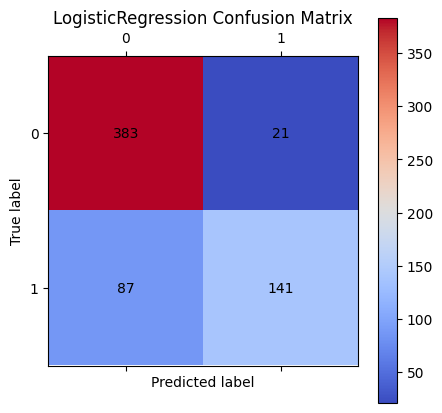

Report: 
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       404
           1       0.87      0.62      0.72       228

    accuracy                           0.83       632
   macro avg       0.84      0.78      0.80       632
weighted avg       0.83      0.83      0.82       632



LogisticRegression(C=100, max_iter=300, solver='newton-cg')

In [31]:
training_pipeline(task='aa',alg=1,train_fn=trump_path) # About 10 sec (with CUDA)

Best Parameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Confusion Matrix


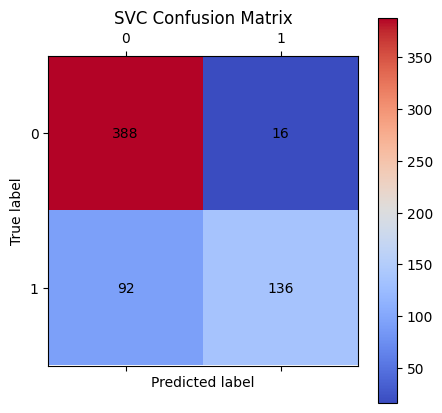

Report: 
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       404
           1       0.89      0.60      0.72       228

    accuracy                           0.83       632
   macro avg       0.85      0.78      0.80       632
weighted avg       0.84      0.83      0.82       632



SVC(C=1)

In [32]:
training_pipeline(task='aa',alg=2,train_fn=trump_path) # about 15 sec (with CUDA)

Epoch:1 || Epoch Accuracy: 0.62607 || Val Acc: 0.63802 || Average Accumulated Loss: 0.71009 || Validation Loss: 0.68344 || Time Taken: 3.69465
Epoch:2 || Epoch Accuracy: 0.65156 || Val Acc: 0.73073 || Average Accumulated Loss: 0.68123 || Validation Loss: 0.66507 || Time Taken: 0.25227
Epoch:3 || Epoch Accuracy: 0.72197 || Val Acc: 0.73021 || Average Accumulated Loss: 0.66430 || Validation Loss: 0.66120 || Time Taken: 0.25647
Epoch:4 || Epoch Accuracy: 0.74621 || Val Acc: 0.74792 || Average Accumulated Loss: 0.65735 || Validation Loss: 0.65400 || Time Taken: 0.25082
Epoch:5 || Epoch Accuracy: 0.72819 || Val Acc: 0.73542 || Average Accumulated Loss: 0.66133 || Validation Loss: 0.65768 || Time Taken: 0.24428
Epoch:6 || Epoch Accuracy: 0.73757 || Val Acc: 0.71562 || Average Accumulated Loss: 0.65710 || Validation Loss: 0.66397 || Time Taken: 0.26199
Epoch:7 || Epoch Accuracy: 0.73457 || Val Acc: 0.68906 || Average Accumulated Loss: 0.66217 || Validation Loss: 0.67336 || Time Taken: 0.26419

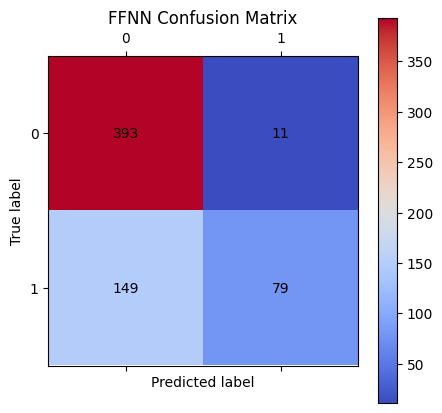

Report: 
              precision    recall  f1-score   support

         0.0       0.73      0.97      0.83       404
         1.0       0.88      0.35      0.50       228

    accuracy                           0.75       632
   macro avg       0.80      0.66      0.66       632
weighted avg       0.78      0.75      0.71       632



FFNN(
  (model): Sequential(
    (0): Linear(in_features=909, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (7): Linear(in_features=8, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [33]:
training_pipeline(task='aa',alg=3,train_fn=trump_path) # about 25 sec (with CUDA)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 30}
Confusion Matrix


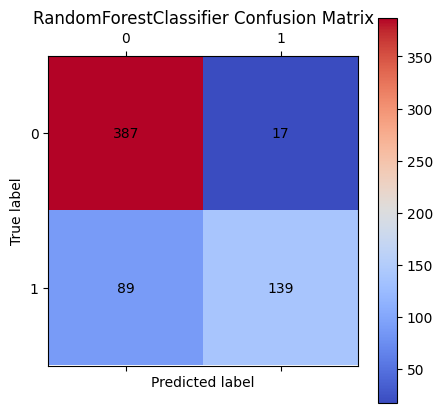

Report: 
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       404
           1       0.89      0.61      0.72       228

    accuracy                           0.83       632
   macro avg       0.85      0.78      0.80       632
weighted avg       0.84      0.83      0.82       632



RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=30)

In [34]:
training_pipeline(task='aa',alg=4,train_fn=trump_path) # about 60 sec (with CUDA)

Current Epoch: 1, Total Average Loss: 0.45503
Current Epoch: 2, Total Average Loss: 0.23554
Current Epoch: 3, Total Average Loss: 0.13406
Current Epoch: 4, Total Average Loss: 0.06763
Current Epoch: 5, Total Average Loss: 0.06382
Current Epoch: 6, Total Average Loss: 0.02922
Current Epoch: 7, Total Average Loss: 0.03180
Current Epoch: 8, Total Average Loss: 0.05760
Current Epoch: 9, Total Average Loss: 0.01658
Current Epoch: 10, Total Average Loss: 0.02086
Confusion Matrix


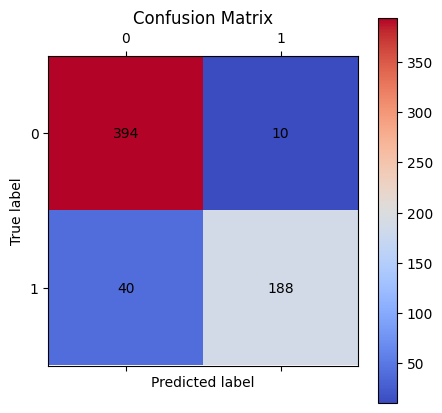

Report: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       404
           1       0.95      0.82      0.88       228

    accuracy                           0.92       632
   macro avg       0.93      0.90      0.91       632
weighted avg       0.92      0.92      0.92       632



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30543, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [35]:
training_pipeline(task='aa',alg=5,train_fn=trump_path) # about 8 min (with CUDA)

## Retrain best model:

Current Epoch: 1, Total Average Loss: 0.44994
Current Epoch: 2, Total Average Loss: 0.23402
Current Epoch: 3, Total Average Loss: 0.15759
Current Epoch: 4, Total Average Loss: 0.11338
Current Epoch: 5, Total Average Loss: 0.05412
Current Epoch: 6, Total Average Loss: 0.03638
Current Epoch: 7, Total Average Loss: 0.04248
Current Epoch: 8, Total Average Loss: 0.02813
Current Epoch: 9, Total Average Loss: 0.03063
Current Epoch: 10, Total Average Loss: 0.01357
Confusion Matrix


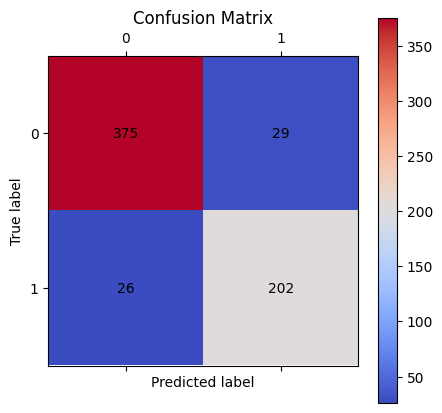

Report: 
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       404
           1       0.87      0.89      0.88       228

    accuracy                           0.91       632
   macro avg       0.90      0.91      0.91       632
weighted avg       0.91      0.91      0.91       632



In [36]:
m = retrain_best_model('aa')

## Predict with best model:

In [38]:
test_path = '/content/trump_tweets_test_a.tsv'
preds = predict(m, test_path, task='aa')
preds

['1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0']

# Experiment & evaluations for Text Classification

## Train five models:

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the n

Best Parameters:  {'C': 0.1, 'solver': 'newton-cg'}
Confusion Matrix


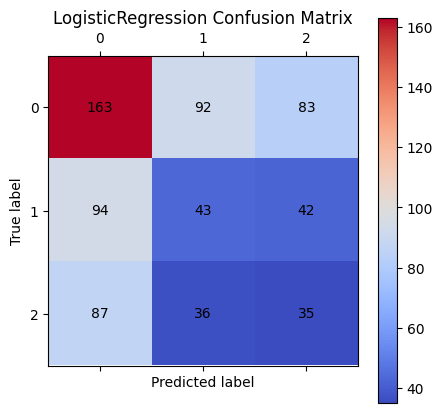

Report: 
              precision    recall  f1-score   support

         0.0       0.47      0.48      0.48       338
         1.0       0.25      0.24      0.25       179
         2.0       0.22      0.22      0.22       158

    accuracy                           0.36       675
   macro avg       0.31      0.31      0.31       675
weighted avg       0.36      0.36      0.36       675



LogisticRegression(C=0.1, solver='newton-cg')

In [39]:
training_pipeline(task='c',alg=1,train_fn=trump_path) # About 25 min (with CUDA)

Best Parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Confusion Matrix


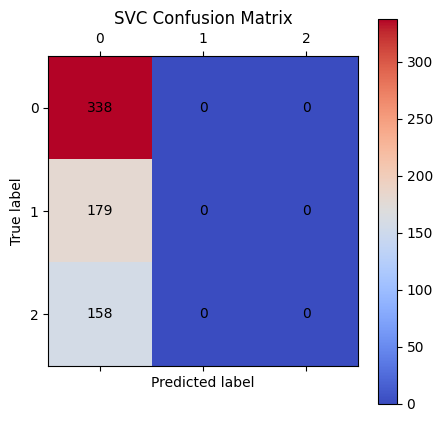

Report: 
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       338
         1.0       0.00      0.00      0.00       179
         2.0       0.00      0.00      0.00       158

    accuracy                           0.50       675
   macro avg       0.17      0.33      0.22       675
weighted avg       0.25      0.50      0.33       675



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC(C=0.1)

In [40]:
training_pipeline(task='c',alg=2,train_fn=trump_path) # about 1 min (with CUDA)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:1 || Epoch Accuracy: 0.48750 || Val Acc: 0.49384 || Average Accumulated Loss: 1.07701 || Validation Loss: 1.05848 || Time Taken: 0.29047
Epoch:2 || Epoch Accuracy: 0.51544 || Val Acc: 0.49384 || Average Accumulated Loss: 1.03917 || Validation Loss: 1.05713 || Time Taken: 0.34344
Epoch:3 || Epoch Accuracy: 0.52316 || Val Acc: 0.49384 || Average Accumulated Loss: 1.03247 || Validation Loss: 1.05755 || Time Taken: 0.58903
Epoch:4 || Epoch Accuracy: 0.52684 || Val Acc: 0.49384 || Average Accumulated Loss: 1.02486 || Validation Loss: 1.05756 || Time Taken: 0.58694
Epoch:5 || Epoch Accuracy: 0.52757 || Val Acc: 0.49384 || Average Accumulated Loss: 1.02569 || Validation Loss: 1.05756 || Time Taken: 0.56928
Epoch:6 || Epoch Accuracy: 0.53015 || Val Acc: 0.49384 || Average Accumulated Loss: 1.02183 || Validation Loss: 1.05758 || Time Taken: 0.59504
Epoch:7 || Epoch Accuracy: 0.52574 || Val Acc: 0.49384 || Average Accumulated Loss: 1.02390 || Validation Loss: 1.05756 || Time Taken: 0.53700

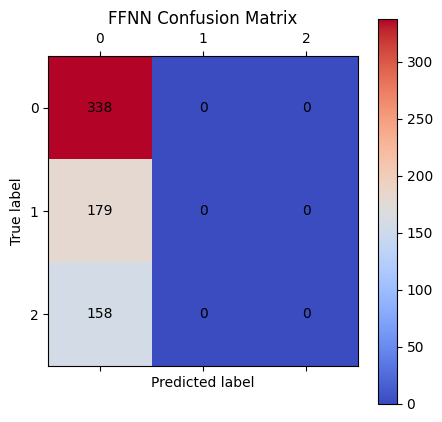

Report: 
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       338
         1.0       0.00      0.00      0.00       179
         2.0       0.00      0.00      0.00       158

    accuracy                           0.50       675
   macro avg       0.17      0.33      0.22       675
weighted avg       0.25      0.50      0.33       675



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FFNN_clf(
  (model): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (7): Linear(in_features=8, out_features=3, bias=True)
    (8): Softmax(dim=None)
  )
)

In [41]:
training_pipeline(task='c',alg=3,train_fn=trump_path) # about 15 sec (with CUDA)

Best Parameters:  {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 10}
Confusion Matrix


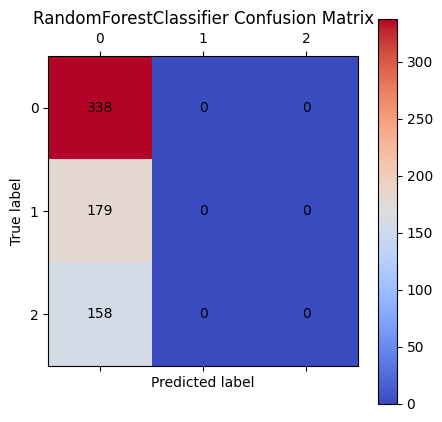

Report: 
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       338
         1.0       0.00      0.00      0.00       179
         2.0       0.00      0.00      0.00       158

    accuracy                           0.50       675
   macro avg       0.17      0.33      0.22       675
weighted avg       0.25      0.50      0.33       675



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier(max_depth=1, n_estimators=10)

In [42]:
training_pipeline(task='c',alg=4,train_fn=trump_path) # about 3 min (with CUDA)

Current Epoch: 1, Total Average Loss: 1.20524
Current Epoch: 2, Total Average Loss: 0.63398
Current Epoch: 3, Total Average Loss: 0.46248
Current Epoch: 4, Total Average Loss: 0.37435
Current Epoch: 5, Total Average Loss: 0.30618
Current Epoch: 6, Total Average Loss: 0.17774
Current Epoch: 7, Total Average Loss: 0.08899
Current Epoch: 8, Total Average Loss: 0.04597
Current Epoch: 9, Total Average Loss: 0.04194


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Current Epoch: 10, Total Average Loss: 0.02402
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       525
           1       0.54      0.64      0.59       278
           2       0.57      0.56      0.57       215

    accuracy                           0.72      1018
   macro avg       0.67      0.68      0.67      1018
weighted avg       0.73      0.72      0.72      1018

Confusion Matrix


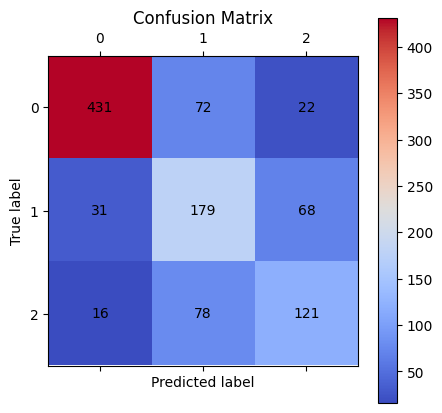

Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       525
           1       0.54      0.64      0.59       278
           2       0.57      0.56      0.57       215

    accuracy                           0.72      1018
   macro avg       0.67      0.68      0.67      1018
weighted avg       0.73      0.72      0.72      1018



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [43]:
training_pipeline(task='c',alg=5,train_fn=trump_path) # about 10 min (with CUDA)

## Retrain best model:

Current Epoch: 1, Total Average Loss: 2.28374
Current Epoch: 2, Total Average Loss: 0.97053
Current Epoch: 3, Total Average Loss: 0.89993
Current Epoch: 4, Total Average Loss: 0.76451
Current Epoch: 5, Total Average Loss: 0.62953
Current Epoch: 6, Total Average Loss: 0.52319
Current Epoch: 7, Total Average Loss: 0.42689
Current Epoch: 8, Total Average Loss: 0.28284
Current Epoch: 9, Total Average Loss: 0.21131


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Current Epoch: 10, Total Average Loss: 0.14969
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       525
           1       0.53      0.69      0.60       278
           2       0.60      0.52      0.56       215

    accuracy                           0.71      1018
   macro avg       0.68      0.67      0.67      1018
weighted avg       0.74      0.71      0.72      1018

Confusion Matrix


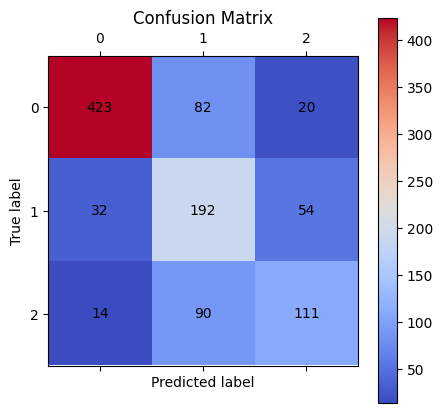

Report: 
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       525
           1       0.53      0.69      0.60       278
           2       0.60      0.52      0.56       215

    accuracy                           0.71      1018
   macro avg       0.68      0.67      0.67      1018
weighted avg       0.74      0.71      0.72      1018



In [44]:
m = retrain_best_model('c')

## Predict with best model:

In [47]:
test_path = '/content/intro2nlp_ex3_covid_test_a - Sheet1.tsv'
preds = predict(m=m, fn=test_path, task='c')
preds

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['2',
 '2',
 '2',
 '1',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '1',
 '2',
 '1',
 '0',
 '0',
 '1',
 '1',
 '2',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '2',
 '1',
 '0',
 '2',
 '1',
 '1',
 '0',
 '0',
 '2',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '0',
 '2',
 '1',
 '1',
 '2',
 '0',
 '1',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '0',
 '2',
 '1',
 '0',
 '1',
 '2',
 '2',
 '1',
 '2',
 '0',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '2',
 '1',
 '0',
 '2',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '2',
 '1',
 '1',
 '2',
 '1',
 '0',
 '0',
 '0',
 '2',
 '2',
 '0',
 '0',
 '1',
 '0',
 '1',
 '0',
 '0',
 '1',
 '2',
 '2',
 '2',
 '0',
 '0',
 '2',
 '1',
 '1',
 '2',
 '1',
 '1',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '2',
 '0',
 '1',
 '2',
 '1',
 '0',
 '0',
 '1',
 '2',
 '0',
 '2',
 '1',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '1',
 '1',
 '0',
 '0',
 '2',
 '1',
 '1',
 '1',
 '1',
 '2'

In [49]:
" ".join(preds)

'2 2 2 1 0 0 0 1 0 0 0 0 0 2 1 2 1 0 0 1 1 2 2 0 0 0 0 0 0 2 0 2 1 0 2 1 1 0 0 2 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 2 1 1 2 0 1 0 1 0 1 0 0 0 2 1 0 1 2 2 1 2 0 1 1 0 0 1 0 0 0 2 0 0 2 1 0 2 0 0 0 0 2 0 2 1 1 2 1 0 0 0 2 2 0 0 1 0 1 0 0 1 2 2 2 0 0 2 1 1 2 1 1 0 0 1 0 0 0 1 1 1 2 0 1 2 1 0 0 1 2 0 2 1 0 0 0 0 1 0 1 1 0 0 2 1 1 1 1 2 2 1 0 1 0 0 0 1 0 1 0 1 2 1 1 2 1 0 2 0 1 0 0 1 1 0 2 0 1 1 0 1 1'

In [48]:
def who_am_i():  # this is not a class method
    """Returns a ductionary with your name, id number and email. keys=['name', 'id','email']
        Make sure you return your own info!
    """
    return {'name': 'Alon Schneider | Alon Malach', 'id': '312213978 | 207024878', 'email': 'alonshn@post.bgu.ac.il | alonmal@post.bgu.ac.il'}
who_am_i()

{'name': 'Alon Schneider | Alon Malach',
 'id': '312213978 | 207024878',
 'email': 'alonshn@post.bgu.ac.il | alonmal@post.bgu.ac.il'}